# JCAP images & spectra hackathon
## Intro and motivation
This notebook gives an introduction to the dataset used in the research presented in Stein et al. Chem. Sci., 2019, 10, 47-55 https://doi.org/10.1039/C8SC03077D to generate embeddings from printed images and use them to predict full UV-Vis absorption spectra. The bigger picture for this scientific endeavour is the quest to find materials that are able to split water under irradiation of sunlight (solar water splitting) to generate renewable "solar" fuels. The scientists in the high-throughput experiementation group (HTE) at the Joint Center for Artificial Photosynthesis (JCAP - https://solarfuelshub.org/) therefore utilize ink-jet printing to deposit metal nitrate precursors onto transparent conducting oxides (TCO) that are annealed at high temperatures to form metal oxides. The images in this study (already encoded using a neural network in the dataset here) are optical microscopy images from a consumer grade photo scanner that is able to scan tens of thousands of materials images (ca. 4mm by 4mm) a minute. The information in these images is classic RGB CMOS data. Being able to tell from this very low-cost measurement how the full absorption spectra would qualitatively and quantitaively look like would not just enable the scientists to accelerate their discovery process but to also allow them to use the giant amount of materials images that have never been measured using UV-Vis spectroscopy.
The measurement workflow is shown below.


<img src="./jcap_workflow.png" alt="workflow" width="500">


## Technical introduction / reference

**THIS IS FOR REFERENCE, THERE IS NO NEED TO DOWNLOAD FROM THE EXTERNAL SITE** In their publication Stein et al. used a convolutional variational autoencoder to generate image embeddings, that for the purpose of this notebook, shall function as a surrogate representation of the images. What you have in this notebook is the embeddings for a subset of the over 100k images described by Stein et al. in https://doi.org/10.1038/s41597-019-0019-4 that can be downloaded at https://data.caltech.edu/records/1152 with code to wrangle with the dataset available at https://github.com/helgestein/materials-images-spectra. 
The embeddings for images are already generated for you as this process requires training of a larger deep neural network and takes about 30 min to complete. 

**For the bandgap prediction a word of precaution should be made:** We calculate the bandgap only for those spectra where reasonable values were found for both the predicted and regressed bandgaps. The used algorithm for bandgap extraction is not very stable and can predict bandgaps outside a physically meaningful range. Also, we know that most materials are multiphase thus exhibit more than one bandgap. The algorithm finds the most dominant one.

# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Download files to SageMaker instance from S3.

In [2]:
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

In [22]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:00<00:00, 159MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 24.4kB/s]


Load local files into arrays or Pandas dataframe. Taking part of dataset that contains Fe, Bi, Mn, and V; and one that contains Fe but not those elements.

In [83]:
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df['index'] = range(1, len(jcap_df) + 1)
jcap_df_Fe = jcap_df[jcap_df['Fe']>0]
jcap_df_Fe.shape
jcap_df_Fe_binary = jcap_df_Fe[(jcap_df_Fe['Bi']>0) |(jcap_df_Fe['Mn']>0) | (jcap_df_Fe['V']>0)]
jcap_df_Fe_binary.shape
jcap_df_Fe_noBiMnV = jcap_df_Fe[(jcap_df_Fe['Bi']==0.0) & (jcap_df_Fe['Mn']==0.0) & (jcap_df_Fe['V']==0.0)]
jcap_df_Fe_noBiMnV.shape

(2515, 46)

In [77]:
jcap_df_Fe.shape

(14694, 46)

In [51]:
jcap_df_Fe_binary.shape

(12179, 45)

In [289]:
#define alloy system
Z = ['Fe','Bi', 'Mn','V']
#find all entries that have some amount of elements in Z
jcap_df_new = jcap_df[jcap_df.loc[:,Z[0]] > 0.0]
jcap_df_new = jcap_df[jcap_df.loc[:,Z[1]] > 0.0]
jcap_df_new = jcap_df[jcap_df.loc[:,Z[2]] > 0.0]
jcap_df_new = jcap_df[jcap_df.loc[:,Z[3]] > 0.0]
#total proportion of Z must be at least cutoff
cutoff = 0.8
jcap_df_new = jcap_df[jcap_df.loc[:,Z[0]] + jcap_df.loc[:,Z[1]] > cutoff]
jcap_df_new.shape

(905, 47)

Look at the first few rows of the dataframe.

The dataframe is indexed with an entry id associated with a unique composition. The bandgap, 100-dimensional encoding from variational autoencoder in the reference, the optical-UV spectrum, and the atomic fraction of each element are listed for each entry.

In [292]:
# Partition data into seed and candidate data
k_seed_data = jcap_df_new
k_candidate_data = jcap_df
k_candidate_data.drop('bandgap', axis=1)
print(k_seed_data.columns)

Index(['bandgap', 'vae', 'spectrum', 'Fe', 'Sn', 'Ti', 'Zn', 'Ce', 'Co', 'Ni',
       'Bi', 'V', 'Cu', 'Mn', 'W', 'Mo', 'La', 'Cr', 'Y', 'Er', 'Sr', 'Gd',
       'Sm', 'Sb', 'Nb', 'Ga', 'In', 'Al', 'Pb', 'Mg', 'Ca', 'Pr', 'Eu', 'Zr',
       'Lu', 'Ba', 'Yb', 'P', 'Sc', 'Ag', 'Tb', 'Nd', 'Pd', 'Hf', 'Rb',
       'index', 'bandgap_pred'],
      dtype='object')


In [295]:
### Implement agent here
from sklearn.ensemble import RandomForestRegressor
def get_bandgap_features(dataframe):
    features = dataframe.drop(['vae','bandgap','spectrum','bandgap_pred'], axis=1, errors='ignore')
    return features


class RFHardnessAgent():
    def get_hypotheses(self, k_candidate_data, k_seed_data):
        # Fit on known data
        y_known = k_seed_data['bandgap']
        x_known = get_bandgap_features(k_seed_data)
        #x_known = np.array(x_known)
        
        regressor = RandomForestRegressor(n_estimators=10)
        regressor.fit(x_known, y_known)
        # Predict unknown data
        x_unknown = get_bandgap_features(k_candidate_data)
        #_unknown = np.array([x_u])
        #x_unknown = x_unknown.reshape(1,-1)
        #x_unknown = x_unknown.transpose(1,0)
        y_predicted = regressor.predict(x_unknown)
        
        # Pick top 5 candidates
        print(y_predicted)
        print(k_candidate_data.shape)
        k_candidate_data['bandgap_pred'] = y_predicted
        k_candidate_data = k_candidate_data.sort_values(
            'bandgap_pred', ascending=False)
    
        top_candidates = k_candidate_data.head(5)
        return top_candidates

In [296]:
### Test agent here
agent = RFHardnessAgent()
hypotheses = agent.get_hypotheses(k_candidate_data, k_seed_data)
hypotheses[['index', 'bandgap', 'bandgap_pred']]

[1.75195909 1.74985059 1.78516678 ... 2.10551931 2.07332497 2.10315206]
(100430, 47)


,index,bandgap,bandgap_pred
comp_id,,,
116155,73329,2.964432,2.947193
89705,62444,2.937011,2.937011
116691,73766,2.865864,2.931038
129986,80923,2.971761,2.929201
117731,74607,2.909725,2.921426


In [298]:
from sklearn.metrics import mean_absolute_error
bandgap = k_candidate_data['bandgap']
bandgap_pred = k_candidate_data['bandgap_pred']
mean_absolute_error(bandgap, bandgap_pred)

0.24098231633427855

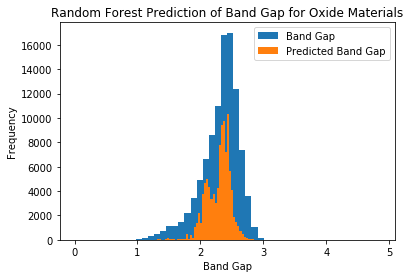

In [321]:
k_candidate_data['bandgap'].plot.hist(bins=50)
k_candidate_data['bandgap_pred'].plot.hist(bins=50)
plt.title('Random Forest Prediction of Band Gap for Oxide Materials')
plt.xlabel('Band Gap')
plt.legend(['Band Gap','Predicted Band Gap'])

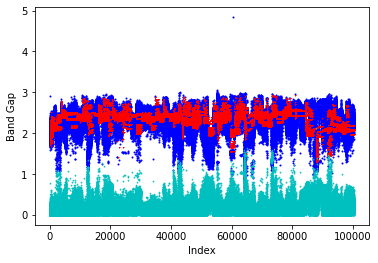

In [354]:
import matplotlib as mp
import matplotlib.pyplot as plt

x = k_candidate_data['index']
y1 = k_candidate_data['bandgap']
y2 = k_candidate_data['bandgap_pred']
ydiff = abs(y2 - y1)
plt.plot(x,y1,'bo',markersize=1,label='Band Gap')
plt.plot(x,y2,'r+',markersize=1,label='Predicted Band Gap')
plt.plot(x,ydiff,'c^',markersize=1)
plt.xlabel('Index')
plt.ylabel('Band Gap')
plt.show()

In [355]:
from camd.experiment.base import ATFSampler

In [356]:
k_atf_experiment = ATFSampler(dataframe=jcap_df)
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()
results

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb,index,bandgap_pred
comp_id,,,,,,,,,,,,,,,,,,,,,
116155,2.964432,"[-0.1761849, 0.16980591, -0.5042865, 0.0426454...","[0.11324286, 0.10231891, 0.09746884, 0.0914828...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,73329,2.947193
89705,2.937011,"[-0.24288009, 0.13357931, -0.49900386, -0.0056...","[0.06363996, 0.060518358, 0.057193223, 0.05409...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.1,0.0,0.0,0.0,0.0,62444,2.937011
116691,2.865864,"[-0.15019393, 0.075011276, -0.45969883, 0.0341...","[0.18243761, 0.17622848, 0.17345327, 0.1671805...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.0,73766,2.931038
129986,2.971761,"[-0.23090717, 0.15733472, -0.77128005, -0.1328...","[0.544462, 0.5220589, 0.50132877, 0.47936872, ...",0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,80923,2.929201
117731,2.909725,"[-0.16177939, 0.1856876, -0.44958714, 0.036106...","[0.08795143, 0.08550065, 0.08481781, 0.0828847...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,74607,2.921426


In [ ]:
Analyzer

In [358]:
from camd.analysis import AnalyzerBase

In [359]:
class BandGapAnalyzer(AnalyzerBase):
    def analyze(self, results, k_seed_data):
        new_seed = pd.concat(
            [k_seed_data, results],
        axis=0)
        # Create a summary
        average_new_bandgap = results.bandgap.mean()
        average_dataset_bandgap = new_seed.bandgap.mean()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
           results.index
        ]
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_bandgap],
            "average_dataset_bandgap": [average_dataset_bandgap],
            "average_rank": [new_result_ranks.mean()]
        })
        return summary, new_seed

In [360]:
k_analyzer = BandGapAnalyzer()
summary, new_seed = k_analyzer.analyze(results,k_seed_data)

In [361]:
summary

,average_new_bandgap,average_dataset_bandgao,average_rank
0,2.929758,2.369035,0.991071


In [362]:
new_seed

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb,index,bandgap_pred
comp_id,,,,,,,,,,,,,,,,,,,,,
0,1.755781,"[-0.31556356, 0.08774113, -0.8520775, -0.31919...","[0.10790491, 0.10887808, 0.10989829, 0.1109349...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1,2.139080
1,1.742198,"[-0.12112557, 0.24288416, -0.9173074, -0.15820...","[0.11588116, 0.1168056, 0.117843196, 0.1188294...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,2,2.139080
2,1.771895,"[-0.04941248, 0.16220033, -0.712603, -0.112917...","[0.106575124, 0.10763326, 0.10877366, 0.109730...",0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,3,2.139080
3,1.771431,"[0.0121279415, 0.21519777, -0.9823824, -0.0944...","[0.116964534, 0.117831506, 0.11866215, 0.11943...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4,2.139080
4,1.791558,"[-0.086630665, 0.18296382, -0.90706384, -0.095...","[0.10127419, 0.102086134, 0.102931604, 0.10381...",0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,5,2.139080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116155,2.964432,"[-0.1761849, 0.16980591, -0.5042865, 0.0426454...","[0.11324286, 0.10231891, 0.09746884, 0.0914828...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,73329,2.947193
89705,2.937011,"[-0.24288009, 0.13357931, -0.49900386, -0.0056...","[0.06363996, 0.060518358, 0.057193223, 0.05409...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.1,0.0,0.0,0.0,0.0,62444,2.937011
116691,2.865864,"[-0.15019393, 0.075011276, -0.45969883, 0.0341...","[0.18243761, 0.17622848, 0.17345327, 0.1671805...",0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.10,0.0,0.0,0.0,0.0,0.0,73766,2.931038
